# UQ Analysis of RFQ Dataset (09-24-2020)

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3);
                                         font-size: 15px">
        <strong>Requirements:</strong>
        <ul>
            <li>pyOPALTools (https://gitlab.psi.ch/OPAL/pyOPALTools/-/tags/pyOPALTools-25-09-2020)</li>
            <li>UQTk (https://github.com/sandialabs/UQTk)</li>
        </ul>
    </div>
</html>
    

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Define Global Variables</strong>
    </div>
</html>

In [13]:
# renamed file: 'Dataset_RFQ-model_01_(09-24-2020).txt' --> 'dataset_0.json'
fname = 'dataset_0.json'

# polynomial chaos expansion order
order = 2
iteration = 1

In [14]:
from db import mldb
import numpy as np


#from mllib.model import *
#from mllib.data import OpalDataSource
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

database = mldb.mldb()

database.buildFromSampler(fname, '.', '')

OPAL ML Database Generator 
Write ML-Database sampler.pk


In [15]:
database.printOverview ()

xDim        = 23 -> ['DVAR1', 'DVAR2', 'DVAR3', 'DVAR4', 'DVAR5', 'DVAR6', 'DVAR7', 'DVAR8', 'DVAR9', 'DVAR10', 'DVAR11', 'DVAR12', 'DVAR13', 'DVAR14', 'DVAR15', 'DVAR16', 'DVAR17', 'DVAR18', 'DVAR19', 'DVAR20', 'DVAR21', 'DVAR22', 'DVAR23']
yDim        = 7 -> ['OBJ1', 'OBJ2', 'OBJ3', 'OBJ4', 'OBJ5', 'OBJ6', 'OBJ7']
generations = 1
Data points  = 189914
Show first dataset from generation 0: y = f(x)
[3.860e+01 7.813e+01 5.900e-02 3.200e+01 6.767e-02 5.917e-02 6.448e-02] = f([ 3.71075400e+00  1.09702490e+01 -4.82822200e+01 -3.22640300e+00
  5.98268900e+00  1.87969530e+01  3.92952568e+02  1.15695680e+01
  1.33398551e+02  1.57871634e+02  1.69266700e+00  1.83418200e+00
  3.77366858e+02  4.71364189e+02  3.15951420e+01  4.30351050e+01
 -5.34608370e+01 -3.23305160e+01  3.49221138e+02  4.98208768e+02
  1.95883600e+00 -2.44117280e+01  5.63830000e-02])


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Save Input and Output</strong>
    </div>
</html>

In [16]:
"""Note: The ordering of the intput and output data are ordered according to 'xnames' and 'ynames' which does not
necessarily mean an increasing ordering, i.e., DVAR1, DVAR2, ... or OBJ1, OBJ", ..., respectively.
"""
import numpy as np
xnames = database.getXNames()
ynames = database.getYNames()
xdim = database.getXDim()
ydim = database.getYDim()
nsamples = database.getSampleSize()

In [17]:
xvals = np.zeros((nsamples, xdim))
yvals = np.zeros((nsamples, ydim))
for i in range(nsamples):
    xvals[i] = database.getDVarVec(0, i)
    yvals[i] = database.getObjVec(0, i)

# save data, might be used for Neural Network training
np.save('rfq_input.npy', xvals)
np.save('rfq_output.npy',yvals)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Obtain Domain of Interest from Data</strong>
    </div>
</html>

In [18]:
import numpy as np
pdom = np.empty((2, len(xnames)))

bounds = database.getBounds()

for i in range(len(xnames)):
    pdom[0, i] = bounds[xnames[i]][0]
    pdom[1, i] = bounds[xnames[i]][1]

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Split into Training and Validation Data</strong>
    </div>
</html>

In [19]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(xvals, yvals, test_size=0.3, random_state=42)

print('Training size:   ', np.shape(xtrain)[0])
print('Validation size: ', np.shape(ytest)[0])
#ytrain = keras.utils.to_categorical(ytrain)

#ytest = keras.utils.to_categorical(ytest)

Training size:    132939
Validation size:  56975



<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Analysis Functions</strong>
    </div>
</html>

###  Error Measures and Sensitivity Computation

In [20]:
# error measures
def eval_l2_error(ytrue, ypred):
    return np.linalg.norm(ytrue - ypred, ord=2) / np.linalg.norm(ytrue, ord=2)

def eval_l1_error(ytrue, ypred):
    return np.linalg.norm(ytrue - ypred, ord=1) / np.linalg.norm(ytrue, ord=1)

def compute_sensitivity(xtrain, ytrain, order, pdom):
    import numpy as np
    allsens_m = np.zeros((len(ytrain[0]), len(xtrain[0])))
    allsens_t = np.zeros((len(ytrain[0]), len(xtrain[0])))
    
    # load the UQ interface
    from surrogate.uqtk_model import UQTk as UQ
    #from surrogate.chaospy_model import UQChaospy as UQ
    
    
    for i in range(len(ytrain[0])):
        # delete
        uq = None

        # setup the UQ analysis ( lsq : least squares method )
        uq = UQ(pdom=pdom, order=order, method='lsq')
    
        # train the surrogate model
        uq.fit(xtrain, ytrain[:, i])
        
        allsens_m[i, :] = uq.main_sensitivity()
        allsens_t[i, :] = uq.total_sensitivity()
    
    return allsens_m, allsens_t

###  Sensitivity Plotting Tools

In [21]:
def plot_sens(sensdata,pars,cases,vis="bar",
              par_labels=[], case_labels=[],colors=[],ncol=4,grid_show=True,xlbl='',
              legend_show=2,xdatatick=None,figname='sens.eps',showplot=False, **kwargs):

    """Plots sensitivity for multiple observables"""
    import matplotlib.pyplot as plt
    ncases=sensdata.shape[0]
    npar=sensdata.shape[1]
    
    sens_type = kwargs.pop('sens_type', '')

    wd=0.6
    ylbl= sens_type + ' Sensitivity'


    assert set(pars) <= set(range(npar))
    assert set(cases) <= set(range(ncases))

    npar_=len(pars)
    ncases_=len(cases)

    case_labels_=[]
    for i in range(ncases_):
        case_labels_.append(case_labels[cases[i]])

    if xdatatick==None:
        xflag=False
        xdatatick=np.array(list(range(1,ncases_+1)))
        sc=1.
    else:
        xflag=True
        sc=(xdatatick[-1]-xdatatick[0])/ncases_

    if (vis=="graph"):
        for i in range(npar_):
            plt.plot(xdatatick_,sensdata[cases,i], '-o',color=colors[pars[i]], label=par_labels[pars[i]])
    elif (vis=="bar"):
        curr=np.zeros((ncases_))
        #print pars,colors
        for i in range(npar_):
            plt.bar(xdatatick,sensdata[cases,i], width=wd*sc,color=colors[pars[i]], bottom=curr,
                    label=par_labels[pars[i]], capsize=5, ecolor='black')
            curr=sensdata[cases,i]+curr
        if not xflag:
            plt.xticks(np.array(list(range(1,ncases_+1))),case_labels_)
        plt.xlim(xdatatick[0]-wd*sc/2.,xdatatick[-1]+wd*sc/2.)

    plt.ylabel(ylbl)
    plt.xlabel(xlbl)

    maxsens=max(max(curr),1.0)
    plt.ylim([0,maxsens])
    if legend_show==1:
        plt.legend()
    elif (legend_show==2):
        plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.1), ncol=ncol)
    elif legend_show == 3:
        bb_shift = kwargs.pop('bb_shift', 0.0)
        plt.legend(loc = 'upper left', bbox_to_anchor=(-0.75+bb_shift, 1.25), ncol=ncol)
        #legend(bbox_to_anchor=(0.0, -0.05),fancybox=True, shadow=True,ncol=5,labelspacing=-0.1)

    #if not xflag:
    #    zed = [tick.label.set_fontsize(xticklabel_size) for tick in plt.gca().xaxis.get_major_ticks()]

    plt.grid(grid_show, linestyle='dashed', axis='y')
    #plt.tight_layout()
    return plt

def plot_sensitivity(sensdata, dnames, outnames, **kwargs):
    import matplotlib.pyplot as plt
    ## Get basic dimensions
    nout=len(outnames)
    ndim=np.shape(sensdata)[1]
    print("Dimensionality : ", ndim)
    print("Num of outputs : ", nout)

    pars=list(range(ndim))
    cases=list(range(nout))

    # 11. March 2019
    # https://stackoverflow.com/questions/43938425/matplotlib-change-colormap-tab20-to-have-three-colors
    colors = plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )

    return plot_sens(sensdata, pars, cases, vis='bar', colors=colors,
                     par_labels=dnames,case_labels=outnames,ncol=int(0.5*ndim),
                     grid_show=True, xlbl='', **kwargs)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Train UQ Model and Check the Error</strong>
    </div>
</html>

In [22]:
#!/usr/bin/env python
"""Demonstrate Keras model weight shuffling as fast alternative to re-creating a model."""

from __future__ import print_function

import numpy as np
from keras.layers import Dense
from keras.models import Sequential


def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


# def main():
#     """Train a simple single layer to learn the sum of three inputs.
#     Shuffle weights in a mock "cross-validation" loop instead of re-creating the model to save time.
#     """
#     np.random.seed(42)
#     model = Sequential((
#         Dense(input_dim=3, output_dim=1, activation='linear'),
#     ))
#     model.compile(loss='msle', optimizer='rmsprop')

#     X = np.random.random(size=(1000, 3))
#     y = np.sum(X, axis=1)

#     initial_weights = model.get_weights()
#     print('Initial weights:\n', initial_weights)

#     for rnd in xrange(3):
#         shuffle_weights(model, initial_weights)
#         print('\nRound {} starting weights:\n'.format(rnd), model.get_weights())
#         hist = model.fit(X, y, nb_epoch=50, verbose=0)
#         print('Learned weights:\n', model.get_weights(), '\nloss:', hist.history['loss'][-1])


# if __name__ == '__main__':
#     main()

In [23]:


class Antirectifier(layers.Layer):
    def __init__(self, initializer="he_normal", **kwargs):
        super(Antirectifier, self).__init__(**kwargs)
        self.initializer = keras.initializers.get(initializer)

    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(output_dim * 2, output_dim),
            initializer=self.initializer,
            name="kernel",
            trainable=True,
        )

    def call(self, inputs):
        inputs -= tf.reduce_mean(inputs, axis=-1, keepdims=True)
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        concatenated = tf.concat([pos, neg], axis=-1)
        mixed = tf.matmul(concatenated, self.kernel)
        return mixed

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(Antirectifier, self).get_config()
        config = {"initializer": keras.initializers.serialize(self.initializer)}
        return dict(list(base_config.items()) + list(config.items()))


In [24]:
# load the UQ interface
#from surrogate.uqtk_model import UQTk as UQ
#from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

#xtrain = xtrain.reshape(-1,14)
#ytrain=ytrain.reshape(-1,6)
models=[]

# Training parameters
batch_size = 500

epochs = 10000

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else: 
        return v / norm


model = Sequential()
model.add(Dense(14, input_dim=2, activation='sigmoid'))
#model.add(Dropout(0.5))
#add in sigmoids/tanh
#check bias terms
#go big immediately
#plot loss

#model.add(Dense(24, activation='relu'))
#model.add(Dropout(0.2))

#model.add(Dense(48, activation='relu'))
#model.add(Dropout(0.5))


#model.add(Dense(100, activation='tanh'))
#model.add(Dropout(0.8))


# model.add(Dense(80, activation='sigmoid'))

# model.add(Dense(50, activation='tanh'))

# model.add(Dense(50, activation='tanh'))

# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='sigmoid'))




model.add(Dense(10, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(14, activation='tanh'))





# model.add(Dense(100, activation='tanh'))

# model.add(Dense(100, activation='tanh'))

# model.add(Dense(48, activation='sigmoid'))
# #model.add(Dropout(0.8))

# model.add(Dense(24, activation='sigmoid'))
# #model.add(Dropout(0.2))

# model.add(Dense(20, activation='sigmoid'))
#model.add(Dropout(0.5))
# never reduces smaller than input

model.add(Dense(1, activation='sigmoid'))

#model.add(Dense(6))
model.summary()







obj=2
models=[]
norms=[]

print(len(ytrain[:,obj]))
print(len(ytrain[obj,:]))
while obj<3:
    
    
    # Compile the model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    #use loss squared function
    #optimizer=keras.optimizers.Adam(learning_rate=.0136),
    optimizer=keras.optimizers.Adam(learning_rate=.001),
    #switch to adam
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

    
    normfactor=np.max(ytrain[:,obj])*1.1
    print(normfactor)
    #normfactor=normalize(ytrain[:,obj])
    #trainer=normalize(ytrain[:,obj])
    norms.append(normfactor)
    model.fit(xtrain, ytrain[:,obj]/normfactor, batch_size=batch_size, epochs=epochs, validation_split=0.0)
    # Test the model
    #model.evaluate(xtest, ytest[:,obj])
    models.append(model)
    obj=obj+1
    #shuffle_weights(model, weights=None)
    
obj=1


#print(xtrain[1,:])
#print(ytrain[9,:])





    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 14)                42        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 14)                294       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 15        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
____________________________________________________

ValueError: in user code:

    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/loyd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 23]


In [24]:
#print(ytest[90,:])
print(norms)
#models[0].predict(xtest)[90]*norms[0]

print("-------------")
#print(pow(np.average(models[0].predict(xtest)*norms[0]-ytest[:,2]),2))
#print("ytest: ", ytest[:,5])
print("predictions: ", abs(models[0].predict(xtest)*norms[0]))
      
predictions =[]
predictions=models[0].predict(xtest)*norms[0]


#1087.4565184720586

# print("***************")
# print("MAE: ", np.average(abs(predictions-ytest[:,2])))
# print("normalized MAE: ", np.average(abs(models[0].predict(xtest)*norms[0]-ytest[:,2]))/np.average(ytrain[:,2]))

difs=[]
q=0
while q<len(predictions)-1:
   difs.append(abs(predictions[q]-ytest[q,2]))
   q=q+1
    
print("%%%%%%%%%%%%%%%%%%")
print("MAE: ", np.average(difs))
print("normalized MAE: ", np.average(difs)/np.average(ytrain[:,2]))
    

# print("&&&&&&&&&&&&&&&&&&&&&&&&&")
# print("prediction:",( models[0].predict(xtest)[90]*norms[0]) )
# print("ytest:",ytest[90,2])


# print("^^^^^^^^^^^^^^^^")
# q=0
# while q<len(predictions)-1:
#     #print(q)
#     if (abs(predictions[q]-ytest[q,2])) > 10:
#         print("q: " , q, "   prediction: ", predictions[q], "       ytest: ", ytest[q,2], "   dif: ", abs(predictions[q]-ytest[q,2]) )
#     q=q+1

[0.044000000000000004]
-------------
predictions:  [[0.03210482]
 [0.03610436]
 [0.03666614]
 [0.03208328]
 [0.03158597]
 [0.03169082]
 [0.0321293 ]
 [0.04048665]
 [0.03227307]
 [0.03000356]
 [0.04021327]
 [0.03384917]
 [0.03775004]
 [0.03220446]
 [0.03462695]
 [0.03868614]
 [0.03174311]
 [0.04000011]
 [0.03206446]
 [0.02986591]
 [0.03007286]
 [0.0301525 ]
 [0.02900578]
 [0.0297471 ]
 [0.02960629]
 [0.03205606]
 [0.04021931]
 [0.03208014]
 [0.03009423]
 [0.03836489]]
%%%%%%%%%%%%%%%%%%
MAE:  0.0035877137
normalized MAE:  0.10641523680286641


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

obj = 0
#print(xtrain)


while obj<1:
    predictions=[]
    #predictions=models[obj].predict(xtest)*norms[obj]
    #predictions=models[obj].predict(xtest)*norms[obj]
    predictions=model.predict(xtest)*normfactor
    
    print(len(models))
    #print(len(predictions[:,obj]))
    #print(len(ytest))
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    

    ax2.scatter(ytest[:,obj], ytest[:,obj],
             
             label='y=x',
            s=1, c='b', marker="s",
             )
    ax2.scatter(ytest[:,obj], predictions,
             s=.01, c='r', marker="o",
             label='Prediction')
    ax2.set_aspect(1)
    
    
    
    
    if obj==0:
        ax2.set_xlabel('transmission(%)')
        ax2.set_ylabel('transmission(%)')
    
    if obj==1:
        ax2.set_xlabel('Energy(MeV)')
        ax2.set_ylabel('Energy(MeV)')
        
    if obj==2:
        ax2.set_xlabel('length(mm)')
        ax2.set_ylabel('length(mm)')
        
    
    if obj==3:
        ax2.set_xlabel('Longitudinal emit (mm*mrad)')
        ax2.set_ylabel('Longitudinal emit (mm*mrad)')
        
        
    
    if obj==4:
        ax2.set_xlabel('X emit (mm*mrad)')
        ax2.set_ylabel('X emit (mm*mrad)')
                
    if obj==5:
        ax2.set_xlabel('Y emit (mm*mrad)')
        ax2.set_ylabel('Y emit (mm*mrad)')
        

    #ax2.set_xlim(0.055, .1)
    #ax2.set_ylim(0, .1)
    #ax2.set_xlim(0, .1)
    plt.legend(loc='upper left');
    

#plt.plot(xvals[:,1], yvals[:,1], label='')
    plt.show()
    obj = obj +1


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Generate Database</strong>
    </div>

</html>

TypeError: No loop matching the specified signature and casting was found for ufunc add

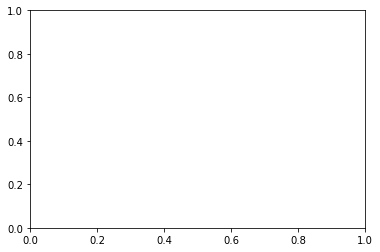

In [58]:
obj = 4
#print(xtrain)

import matplotlib.pyplot as plt
from scipy.stats import kde


while obj<5:
    
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    #ytrain.append(ytrain[1,1])
    #ytest = np.delete(ytest, 0, axis=0)
    #predictions = np.delete(predictions, 2)
#     #np.delete(ytest[:,obj], 1)
#     print(len(predictions))
#     print(len(ytest[:,obj]))
#     print(len(ytrain[:,obj]))


    
    heatplots=True
    if heatplots:
        nbins=300
        k = kde.gaussian_kde( [  ytest[:,obj], predictions  ])
        xi, yi = np.mgrid[ytest[:,obj].min():ytest[:,obj].max():nbins*1j, predictions.min():predictions.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        ax2.pcolormesh(xi, yi, zi.reshape(xi.shape))
        #plt.show()
    
        
    
    ax2.scatter(ytest[:,obj], ytest[:,obj],
             
             label='y=x',
            s=10, c='y', marker="s",
             )
    ax2.scatter(ytest[:,obj], predictions,
             s=.01, c='r', marker="o",
             label='Prediction')
#     ax2.scatter(ytest[:,obj], ytrain[:,obj], 
#              s=1, c='g', marker="o",
#              label='Prediction')
    
    
    
    

    
    
    ax2.set_aspect(1)
    
    
    
    
    
    if obj==0:
        ax2.set_xlabel('transmission(%)')
        ax2.set_ylabel('transmission(%)')
        ax2.set_aspect(1)
        
    if obj==1:
        ax2.set_xlabel('Energy(MeV)')
        ax2.set_ylabel('Energy(MeV)')
        ax2.set_aspect(1)
        
    if obj==2:
        ax2.set_xlabel('length(mm)')
        ax2.set_ylabel('length(mm)')
        ax2.set_aspect(1)
    
    if obj==3:
        ax2.set_xlabel('Longitudinal emit (mm*mrad)')
        ax2.set_ylabel('Longitudinal emit (mm*mrad)')
        ax2.set_aspect(1)
        
    
    if obj==4:
        ax2.set_xlabel('X emit (mm*mrad)')
        ax2.set_ylabel('X emit (mm*mrad)')
        ax2.set_xlim(.01, .07)
        ax2.set_ylim(.01, .07)
                
    if obj==5:
        ax2.set_xlabel('Y emit (mm*mrad)')
        ax2.set_ylabel('Y emit (mm*mrad)')
        ax2.set_xlim(.01, .07)
        ax2.set_ylim(.01, .07)
        ax2.set_aspect(1)
        

    #ax2.set_xlim(0.055, .1)
    #ax2.set_ylim(0, .1)
    #ax2.set_xlim(0, .1)
    plt.legend(loc='upper left');
    

#plt.plot(xvals[:,1], yvals[:,1], label='')
   
    plt.show()
    #print(" value:  ",  pow(np.average(predictions[obj]-ytest[:,obj]), 2)      /       pow(np.average(ytrain[:,obj]), 2))
    print('L2 error norm in validation points: ', eval_l2_error(ytrue=ytest[:, i], ypred=ypred_test))
    obj = obj +1


In [ ]:

import pandas as pd 

from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mclr


voltages=np.array([15,15.5,16,15,15.5,16,15.5,16,15.5,16,16,16,16,17,17.5,18,17.5,18,18])
angles=np.array([20,20,20,20.5,20.5,20.5,21,21,21.5,21.5,22,22.5,23,25,25,25,26,26,27])
emits=np.array([0.000000135,0.000000136197,0.000000138,0.000000133,0.000000135,0.000000136437,0.000000133,0.000000135,0.000000132,0.000000133,0.000000132,0.000000131,0.00000013,0.000000127,0.000000128,0.000000129,0.000000125,0.000000126,0.00000012386])

angle,voltages = np.meshgrid(angles, voltages, indexing='ij')
  
#voltages, angles = np.meshgrid(voltages, angles) 
  
# surface plot for a + b 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.pcolormesh(angles, voltages, emits, edgecolors='w',cmap="plasma")
  
plt.show() 








In [ ]:
# Rho histogram
#fig, ax = plt.subplots()
#
#plt.sca(ax[0, 2])


voltages=np.array([15,15.5,16,15,15.5,16,15.5,16,15.5,16,16,16,16,17,17.5,18,17.5,18,18])
angles=np.array([20,20,20,20.5,20.5,20.5,21,21,21.5,21.5,22,22.5,23,25,25,25,26,26,27])
emits=np.array([0.000000135,0.000000136197,0.000000138,0.000000133,0.000000135,0.000000136437,0.000000133,0.000000135,0.000000132,0.000000133,0.000000132,0.000000131,0.00000013,0.000000127,0.000000128,0.000000129,0.000000125,0.000000126,0.00000012386])
#emits= normalize(emits)

plt.hist2d(angles, voltages,  bins=[10, 10],range=[[19, 28], [13, 20]],
           weights=emits, cmap=plt.cm.rainbow)
plt.clim(.00000012, .00000014)
plt.colorbar()

plt.xlabel("angles")
plt.ylabel("voltages")
plt.title("Charge Density (C/m^3)")
plt.gca().set_aspect(1)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Plot Main and Total Sensitivities</strong>
    </div>
</html>

In [ ]:
from scipy.optimize import minimize_scalar


import itertools as it
import subprocess
from scipy import optimize as opt
import numpy as npr
from time import time, ctime
from datetime import date
from datetime import datetime as dt
import wave
import random
from bayes_opt import BayesianOptimization
import sys
import os

from db import mldb
import numpy as np


#from mllib.model import *
#from mllib.data import OpalDataSource
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def opt_fun (lmax, n, a, learn_rate):

    # list of hyperparams: number of layers(lmax), number of nodes per layer(n[l]), activation function(a[l], =0,1,2) 
    # learning rate
    
    model = Sequential()
    model.add(Dense(14, input_dim=14, activation='sigmoid'))
    
    l=0
    while l<lmax:
        if a[l]==0:
            model.add(Dense(n[l], activation='relu'))
    
        if a[l]==1:
            model.add(Dense(n[l], activation='tanh'))
        if a[l]==2:
            model.add(Dense(n[l], activation='sigmoid'))
        l=l+1
    
    
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Dense(6))
    #model.summary()




# Compile the model
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        #use loss squared function
        optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
        #switch to adam
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )
    
    
    
    obj=5
    models=[]
    norms=[]
    epochs=1000
    batch_size=1024

    print(len(ytrain[:,obj]))
    print(len(ytrain[obj,:]))
    while obj<6:
    
        normfactor=np.max(ytrain[:,obj])*1.1
        print(normfactor)
        #normfactor=normalize(ytrain[:,obj])
        #trainer=normalize(ytrain[:,obj])
        norms.append(normfactor)
        model.fit(xtrain, ytrain[:,obj]/normfactor, batch_size=batch_size, epochs=epochs, validation_split=0.0)
        # Test the model
        #model.evaluate(xtest, ytest[:,obj])
        models.append(model)
        obj=obj+1
        #shuffle_weights(model, weights=None)
    
    obj=5
    
    
    
    utility=99999999999999999999999
    print("MAE: ", np.average(abs(models[0].predict(xtest)*norms[0]-ytest[:,5])))
    utility= -1*np.average(abs(models[0].predict(xtest)*norms[0]-ytest[:,5]))
    
    
    
    print("utility: ", utility)
    return utility
    

In [ ]:
def opt_fun2 (nodes, learn_rate):
    print("nodes: ", round(nodes), "      learn_rate:", learn_rate)
    global iteration 
    iteration = iteration+1
    print("iteration:  ", iteration)
    
    return opt_fun(5,[15,20,20,20, round(nodes)], [1,1,1,1,1], learn_rate)
  

In [ ]:
#print(opt_fun(x0))
#res = minimize(opt_fun, x0, method='nelder-mead',
#               options={'xatol': 1e-5, 'disp': True})
#res = minimize_scalar(opt_fun, bounds=    )

field_scale = 1 # Adjustments to field strength weight for optimization
# Params for optimizer
n_iter = 400
init_points = 20


printout= "words"


def main():
    global printout
    #numProc = mp.cpu_count() # Number of Processes to spawn
    #x0 = np.asarray([000.0, 00.0, 000.0])
    #dimension=14
    start = time()

    print('Optimizing using BO, PP')


    
    

    
    
    #lmax=5
    
    # 18 parameter bounds Format: 'name': (min, max), 
    bnds = {
        'nodes': (1, 80),
        'learn_rate': (0, .01)
        } 

    
    
    # Optimization process
    optimizer = BayesianOptimization(
        f=opt_fun2,
        pbounds=bnds,
        verbose=0,
        random_state=1,
    )

    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )
    results = optimizer.max


    print('-------------------------------------------------')
    print( 'OPTIMIZATION ENDED' )
    print( "utility:", -1*results['target'])
    print ("params: ", results['params'])
    
    printout= 'printout: '
    printout.append("utility: ", -1*results['target'], "           params:", results['params'])

    end = time()
    print("Elapsed time: ", end - start, " seconds")
    


    print("optimization completed:", dt.now().strftime('%y.%m.%d-%H:%M:%S')        )
  
  
main()







In [ ]:
print(printout)

In [ ]:
import matplotlib.pyplot as plt
plt.legend(loc='upper left');
plt.figure(figsize=(12, 9), dpi=150)
plt = plot_sensitivity(allsens_m, dnames=xnames, outnames=ynames, sens_type='Main')

plt.savefig('main_sensitivty_order_' + str(order) + '.png', bbox_inches='tight')
plt.close()

In [ ]:
plt.figure(figsize=(12, 9), dpi=150)
plt = plot_sensitivity(allsens_t, dnames=xnames, outnames=ynames, sens_type='Total')

plt.savefig('total_sensitivty_order_' + str(order) + '.png', bbox_inches='tight')
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(len(xvals))
print(len(yvals))
print(len(ypred_test))
print(len(xtest))

obj=0


while obj<6:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(xvals[:,obj], yvals[:,obj],
             
            label='Data',
           s=10, c='b', marker="s",
            )
    ax1.scatter(xtest[:,obj], ypred_test,
             s=10, c='r', marker="o",
             label='Prediction')

    #ax1.set_ylim(0, 1.)
    plt.legend(loc='upper left');

#plt.plot(xvals[:,1], yvals[:,1], label='')
    plt.show()
    obj = obj +1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

obj = 0
#print(xtrain)


while obj<6:
    predictions=[]
    predictions=models[obj].predict(xtest)*norms[obj]
    print(len(predictions))
    print(len(ytest))
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    

    ax2.scatter(ytest[:,obj], ytest[:,obj],
             
             label='y=x',
            s=1, c='b', marker="s",
             )
    ax2.scatter(ytest[:,obj], predictions,
             s=1, c='r', marker="o",
             label='Prediction')
    ax2.set_aspect(1)
    
    
    
    
    if obj==0:
        ax2.set_xlabel('transmission(%)')
        ax2.set_ylabel('transmission(%)')
    
    if obj==1:
        ax2.set_xlabel('Energy(MeV)')
        ax2.set_ylabel('Energy(MeV)')
        
    if obj==2:
        ax2.set_xlabel('length(mm)')
        ax2.set_ylabel('length(mm)')
        
    
    if obj==3:
        ax2.set_xlabel('Longitudinal emit (mm*mrad)')
        ax2.set_ylabel('Longitudinal emit (mm*mrad)')
        
        
    
    if obj==4:
        ax2.set_xlabel('X emit (mm*mrad)')
        ax2.set_ylabel('X emit (mm*mrad)')
                
    if obj==5:
        ax2.set_xlabel('Y emit (mm*mrad)')
        ax2.set_ylabel('Y emit (mm*mrad)')
        

    #ax2.set_xlim(0.055, .1)
    #ax2.set_ylim(0, .1)
    #ax2.set_xlim(0, .1)
    plt.legend(loc='upper left');
    

#plt.plot(xvals[:,1], yvals[:,1], label='')
    plt.show()
    obj = obj +1


In [ ]:
#print(xtest)




i=0

print("output:  ")
#print(output)
#print(len(output))
print("   ")
print("xtest:   ")
print(xtest)
print(len(xtest[i,:]))
print(len(xtest[:,i]))



xinput = [[10.01277,
102.13058,
11.38499,
150.15528,
149.87416,
32.79421,
47.35732,
91.13554,
1.0339,
1.18602,
1.55939,
-85.4561,
-65.20657,
-56.44278],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]


outputs =[]


# while i<14:
    
#      print(xtest[0,i]         )
#      #outputs.append(output[i])
#      #print(output[i])
     
#      i=i+1

p=0
while p<6:
    outputs.append(surrogates[p].predict(xinput))
    print(surrogates[p].predict(xinput))
    p=p+1    
    print(len(outputs))

print("")    
print("outputs: ")    
print("")
p=0
while p<6:
    print(outputs[p][0])
    p=p+1        
    


    
    
    
weights =[1,1,1,1,1,1,1]
# #utility = 




In [ ]:
i=0
while i<6:
    plt.hist(ytrain[:,i], bins=20)
    
    plt.show()
    i=i+1



In [ ]:
from scipy.optimize import minimize_scalar


import itertools as it
import subprocess
from scipy import optimize as opt
import numpy as npr
from time import time, ctime
from datetime import date
from datetime import datetime as dt
import wave
import random
import multiprocessing as mp
from bayes_opt import BayesianOptimization
import sys
import os




def opt_fun (dvar1,dvar2,dvar3,dvar4,dvar5,dvar6,dvar7,dvar8,dvar9,dvar10,dvar11,dvar12,dvar13,dvar14):
    
    utility=0
#     utility=0
#     dvar1=x[0]
#     dvar2=x[1]
#     dvar3=x[2]
#     dvar4=x[3]
#     dvar5=x[4]
#     dvar6=x[5]
#     dvar7=x[6]
#     dvar8=x[7]
#     dvar9=x[8]
#     dvar10=x[9]
#     dvar11=x[10]
#     dvar12=x[11]
#     dvar13=x[12]
#     dvar14=x[13]
#     obj=x[14]
    
    
    
    
    
    
    
    xinput = [[dvar1,
    dvar2,
    dvar3,
    dvar4,
    dvar5,
    dvar6,
    dvar7, 
    dvar8, 
    dvar9, 
    dvar10,
    dvar11,
    dvar12,
    dvar13, 
    dvar14],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]
    outputs=[]
    outputs.clear()
    obj=6
    p=0
    while p<obj:
        outputs.append(surrogates[p].predict(xinput))
        p=p+1    
    
    
    optimum = [100, 70, 130, 0, 0, 0]
    weights= [ 0.4/50, 0.05/.075, 0.05/140, 0.4/.006, 0.05/.0035, 0.05/.0035]
    obj=6
    
    
    i=0
    while i<obj:
        utility += -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])
        i=i+1
        
    return utility
    
    

x0 = [10.01277,
102.13058,
11.38499,
150.15528,
149.87416,
32.79421,
47.35732,
91.13554,
1.0339,
1.18602,
1.55939,
-85.4561,
-65.20657,
-56.44278,
     6]


#print(opt_fun(x0))
#res = minimize(opt_fun, x0, method='nelder-mead',
#               options={'xatol': 1e-5, 'disp': True})
#res = minimize_scalar(opt_fun, bounds=    )

field_scale = 1 # Adjustments to field strength weight for optimization
# Params for optimizer
n_iter = 1000
init_points = 10




def main():
    numProc = mp.cpu_count() # Number of Processes to spawn
    x0 = np.asarray([000.0, 00.0, 000.0])
    dimension=14
    start = time()

    print('Optimizing using BO, PP')

    #dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min = 30,30,30,30,30,30,30,30,30,30,30,30,30,30
    dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min = 10.01277,102.13058,8.38499,120.15528,129.87416,32.79421,47.35732,91.13554,1.0339,1.18602,1.55939,-85.4561,-5.20657,-56.44278
    #dvar1max, dvar2max, dvar3max, dvar4max, dvar5max, dvar6max, dvar7max, dvar8max, dvar9max, dvar10max, dvar11max, dvar12max,  dvar13max, dvar14max = 40,40,40,40,40,40,40,40,40,40,40,40,40,40
    dvar1max, dvar2max, dvar3max, dvar4max, dvar5max, dvar6max, dvar7max, dvar8max, dvar9max, dvar10max, dvar11max, dvar12max,  dvar13max, dvar14max = 20.01277,112.13058,11.38499,150.15528,150.87416,35.79421,50.35732,96.13554,1.839,2.18602,2.55939,-75.4561,-3.20657,-46.44278

    print(opt_fun(dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min))
    
#     bnds = {
#         (dvar1min, dvar1max),
#         (dvar2min, dvar2max),
#         (dvar3min, dvar3max),
        
#         (dvar4min, dvar4max),
#         (dvar5min, dvar5max),
#         (dvar6min, dvar6max),
#         (dvar7min, dvar7max),
#         (dvar8min, dvar8max),
#         (dvar9min, dvar9max),
#         (dvar10min, dvar10max),
#         (dvar11min, dvar11max),
#         (dvar12min, dvar12max),
        
#         (dvar13min, dvar13max),
#         (dvar14min, dvar14max)
        
#         }
    
    
    
    
    # 18 parameter bounds Format: 'name': (min, max), 
    bnds = {
        'dvar1': (10, 11),
        'dvar2': (1, 200.0),
        'dvar3': (1, 200.0),
        'dvar4': (1, 200.0),
        'dvar5': (1, 200.0),
        'dvar6': (13.0, 33.0),
        'dvar7': (45, 65.0),
        'dvar8': (85, 105.0),
        'dvar9': (1.005, 1.05),
        'dvar10': (1.15, 1.350),
        'dvar11': (1.55, 1.750),
        'dvar12': (-89.9, -85.0),
        'dvar13': (-77.50, -62.50 ),
        'dvar14': (-57.5, -42.5)
        } 

    
    
    # Optimization process
    optimizer = BayesianOptimization(
        f=opt_fun,
        pbounds=bnds,
        verbose=0,
        random_state=1,
    )

    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )
    results = optimizer.max


    print('-------------------------------------------------')
    print( 'OPTIMIZATION ENDED' )
    print( "utility:", -1*results['target'])
    print ("params: ", results['params'])

    end = time()
    print("Elapsed time: ", end - start, " seconds")
    


    print("optimization completed:", dt.now().strftime('%y.%m.%d-%H:%M:%S')        )
  
  
main()







In [ ]:
def opt_fun_2 (dvar1,dvar2,dvar3,dvar4,dvar5,dvar6,dvar7,dvar8,dvar9,dvar10,dvar11,dvar12,dvar13,dvar14):
  
    utility=0
#     utility=0
#     dvar1=x[0]
#     dvar2=x[1]
#     dvar3=x[2]
#     dvar4=x[3]
#     dvar5=x[4]
#     dvar6=x[5]
#     dvar7=x[6]
#     dvar8=x[7]
#     dvar9=x[8]
#     dvar10=x[9]
#     dvar11=x[10]
#     dvar12=x[11]
#     dvar13=x[12]
#     dvar14=x[13]
#     obj=x[14]
    
    
    
    
    
    
    
    xinput = [[dvar1,
    dvar2,
    dvar3,
    dvar4,
    dvar5,
    dvar6,
    dvar7, 
    dvar8, 
    dvar9, 
    dvar10,
    dvar11,
    dvar12,
    dvar13, 
    dvar14],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]
    outputs=[]
    outputs.clear()
    obj=6
    p=0
    while p<obj:
        outputs.append(surrogates[p].predict(xinput))
        p=p+1    
    
    
    optimum = [100, 70, 120, 0, 0, 0]
    weights= [ 0.4/90, 0.05/.075, 0.05/140, 0.4/.06, 0.05/.035, 0.05/.035]
    obj=6
    
    
    i=0
    while i<obj:
        utility += -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])
        print(outputs[i][0])
        i=i+1
        
    
    return utility


#opt_fun_2(10.32654950508622,114.09776918706348,95.03503058186705,  4.9373454675155966, 166.65840782020405,  14.51445462045868, 60.39738085611873, 97.90828399113782,  1.0350016324169173,  1.2932711161614976,  1.6896462159652843,  -88.86681948986129, -76.97132158039432, -47.91867664340158)
#opt_fun_2(10.0,141.20474878480792, 131.412409553512,  4.572527379802288,  35.30223532987305,  33.0,  55.496663301669955,  85.0, 1.05, 1.15,  1.75,  -89.9,  -77.5,  -57.5,)
opt_fun_2( 10.0, 141.20474878480792, 131.412409553512, 4.572527379802288, 35.30223532987305, 33.0, 55.496663301669955, 85.0,  1.05, 1.15,  1.75,  -89.9,  -77.5,  -57.5)